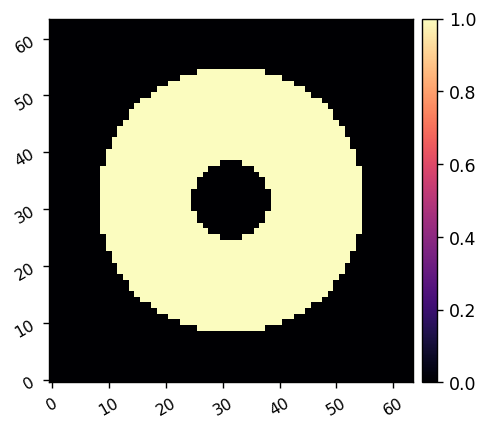

In [8]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time

from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import h5py
import os
from pathlib import Path

import misc
from matplotlib.patches import Circle
from importlib import reload
reload(misc)

# data_dir = Path('C:/Users/Kian/Documents/data-files/disk-processing')
# data_dir = Path('/users/kianmilani/Documents/data-files/disk-processing')
data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf=64
psf_pixelscale_mas = 21.82142167566928*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)
psf_pixelscale_m = psf_pixelscale*u.m/u.pix

polaxis = 10

ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix
disk_pixelscale_lamD = (disk_pixelscale_mas/mas_per_lamD).value

band1_wavelength = 575e-9*u.m
iwa_band1 = 2.8
owa_band1 = 9.7

iwa = iwa_band1 * wavelength_c/band1_wavelength
owa = owa_band1 * wavelength_c/band1_wavelength

iwa_mas = iwa*mas_per_lamD
owa_mas = owa*mas_per_lamD

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
r = np.sqrt(x**2 + y**2)*disk_pixelscale_lamD
mask = np.zeros((ndisk,ndisk))
mask[((r>iwa)*(r<owa))] = 1
misc.myimshow(mask)

In [17]:
import roman_phasec_proper as roman
import proper
proper.__version__, roman.__version__

('3.2.5', '1.2.8')

In [2]:
fov_owa = owa_mas
fov_im = psf_pixelscale_mas * 64/2

print(fov_owa, fov_im)

486.8359175841816 mas 665.6 mas / pix


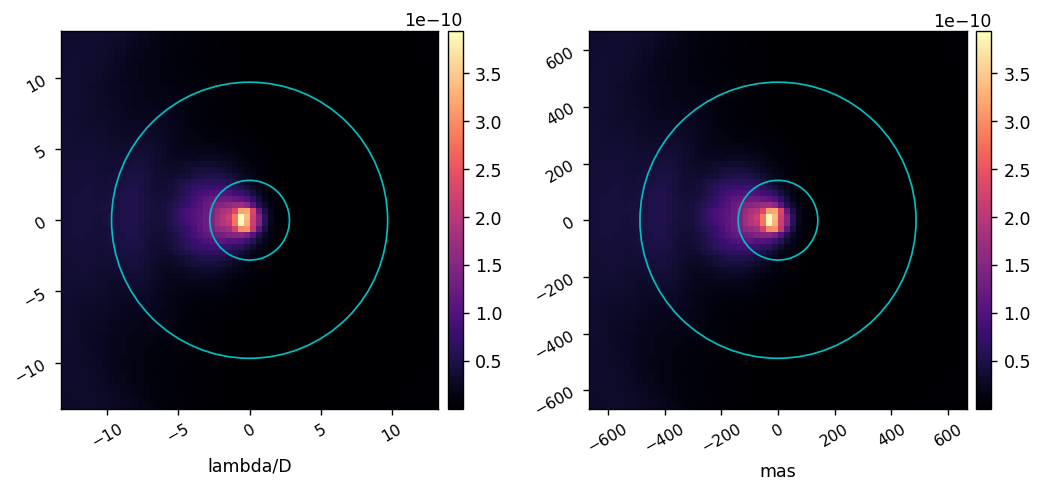

In [9]:
disk_fpath = data_dir/'disks'/'I_0_eps_eri.fits'
# disk_fpath = 'I_135_hlc.fits'

disk = fits.getdata(disk_fpath)
disk = misc.pad_or_crop(disk, ndisk)
disk_hdr = fits.getheader(disk_fpath)

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk, disk, lognorm1=False, lognorm2=False, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )


# Do the matrix multiplication

In [10]:
# ipsf_fpath = data_dir/'ipsfs'/'spc_wide_ipsf_matrix_polaxis{:d}_rtheta_v1.hdf5'.format(polaxis)
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20220920.hdf5'
ipsf_fpath = data_dir/'ipsfs'/'hlc_band1_ipsfs_20221006.hdf5'

f = h5py.File(ipsf_fpath, 'r')
ipsf_matrix = np.array(f['ipsf_matrix'])
f.close()

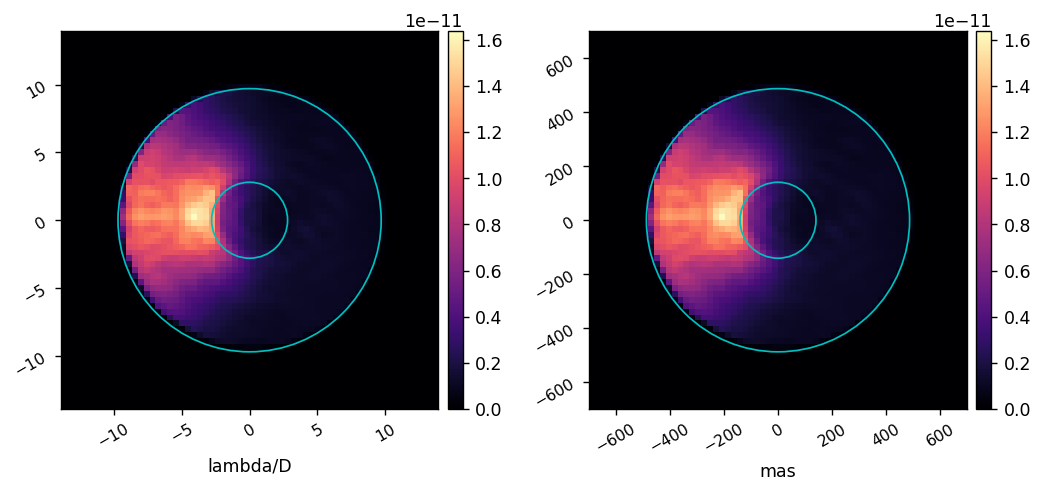

In [11]:
disk_sim = np.reshape(ipsf_matrix.dot(disk.flatten()), (npsf,npsf))

patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk_sim, disk_sim, 
#                lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

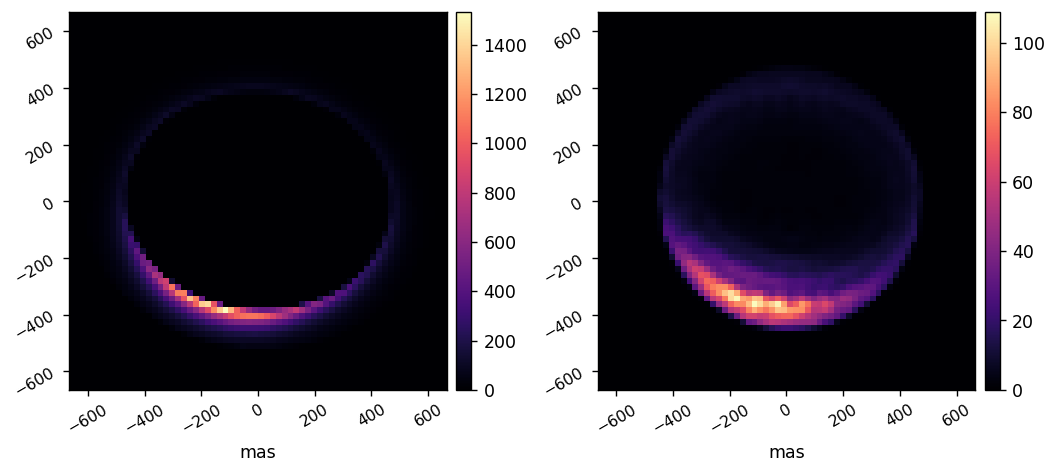

In [5]:
misc.myimshow2(disk, disk_sim,
               pxscl1=disk_pixelscale_mas, pxscl2=psf_pixelscale_mas, )

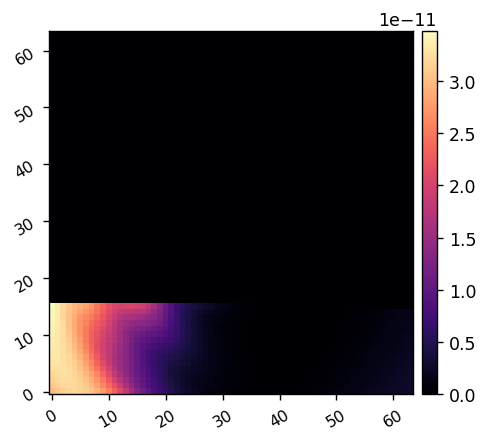

In [20]:
new_disk = disk.flatten()
new_disk[1000:] = 0
misc.myimshow(new_disk.reshape(ndisk,ndisk))

In [22]:
import misc_funs as misc

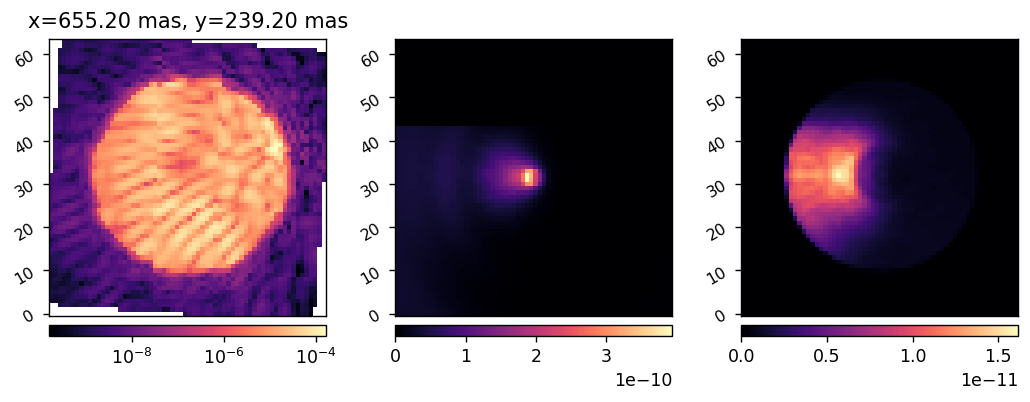

In [25]:
ndisk = 64
disk_pixelscale_mas = 20.8*u.mas/u.pix

x,y = np.meshgrid(np.arange(-ndisk/2,ndisk/2) + 1/2, np.arange(-ndisk/2,ndisk/2)+1/2 )
x = x.flatten()*disk_pixelscale_mas*u.pix
y = y.flatten()*disk_pixelscale_mas*u.pix

start = ipsf_matrix.shape[0]//2
for i in range(start, ipsf_matrix.shape[0]):
    new_disk = disk.flatten()
    new_disk[i:] = 0
    disk_sim = np.reshape(ipsf_matrix.dot(new_disk), (npsf,npsf))
    try:
        misc.imshow3(ipsf_matrix[:,i].reshape(npsf,npsf), new_disk.reshape(ndisk,ndisk), disk_sim,
                       'x={:.2f}, y={:.2f}'.format(x[i], y[i]), 
                       lognorm1=True)
        clear_output(wait=True)
    except KeyboardInterrupt:
        break

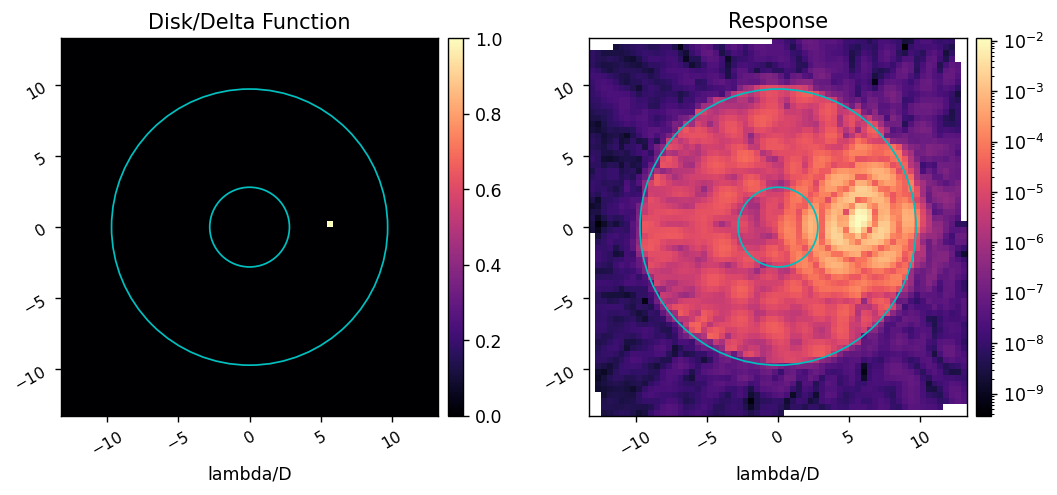

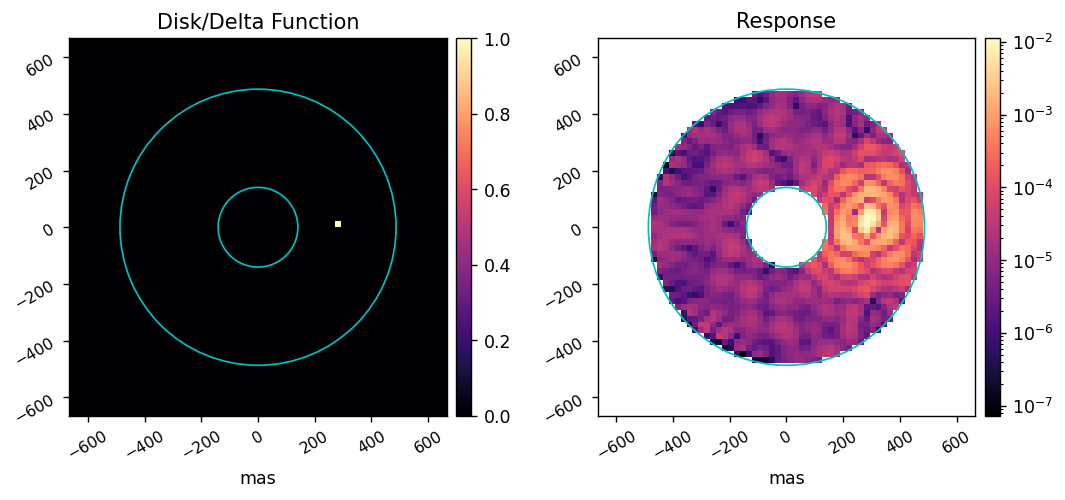

1.0 0.22915871060030296 0.22915871060030296 0.011094788100797554


In [6]:
patches1 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa.value, color='c', fill=False), Circle((0, 0), owa.value, color='c', fill=False)]
misc.myimshow2(disk, disk_sim, 'Disk/Delta Function', 'Response',
               lognorm1=False, 
               lognorm2=True, 
               pxscl1=disk_pixelscale_lamD, pxscl2=disk_pixelscale_lamD, 
               patches1=patches1, patches2=patches2 )

patches1 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
patches2 = [Circle((0, 0), iwa_mas.value, color='c', fill=False), Circle((0, 0), owa_mas.value, color='c', fill=False)]
misc.myimshow2(disk*mask, disk_sim*mask, 'Disk/Delta Function', 'Response',
               lognorm1=False, 
               lognorm2=True, 
               pxscl1=disk_pixelscale_mas, pxscl2=disk_pixelscale_mas, 
               patches1=patches1, patches2=patches2 )

disk_sum = (mask*disk).sum()
im_sum = (mask*disk_sim).sum()

print(disk_sum, im_sum, im_sum/disk_sum, disk_sim.max())

In [9]:
data = np.zeros((2,ndisk,ndisk))
data[0] = disk
data[1] = disk_sim

hdr = fits.Header()
hdr['PIXELSCL'] = 20.8
hdr['DELTASRC'] = 270

data_fits = fits.PrimaryHDU(data=data, header=hdr)
data_fits.writeto('delta_simulation.fits', overwrite=True)